In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

# Importing the dataset

In [176]:
#Importing the dataset
test = pd.read_csv("C:/Users/shiva/Kaggle/google-smartphone-decimeter-challenge/baseline_locations_test.csv")
train = pd.read_csv("C:/Users/shiva/Kaggle/google-smartphone-decimeter-challenge/baseline_locations_train.csv")
#Merging the train set with ground truths
path = Path("google-smartphone-decimeter-challenge")
truths = (path / 'train').rglob('ground_truth.csv')
ground_truths = pd.DataFrame()
for file in truths:
    df = pd.read_csv(file)
    ground_truths = pd.concat([ground_truths, df], ignore_index=True)
ground_truths.drop('heightAboveWgs84EllipsoidM', axis=1, inplace=True)
ground_truths.rename(columns={'latDeg':'latTrue', 'lngDeg':'lngTrue'}, inplace=True)
train = pd.merge(train, ground_truths, on=['phoneName', 'millisSinceGpsEpoch', 'collectionName'])

# Preprocessing

In [177]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_371_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist
def preprocess(df, type):
    trnFls = df['phone'].unique()
    df.loc[:, 'latN'] = 0
    df.loc[:, 'lngN'] = 0
    df.loc[:, 'latP'] = 0
    df.loc[:, 'lngP'] = 0
    df.loc[:, 'msSinceStart'] = 0
    for i in trnFls:
        cond = (df['phone'] == i)
        df.loc[cond, :] = df[cond].sort_values(['millisSinceGpsEpoch'])
        timeWin = df.loc[cond,'millisSinceGpsEpoch']
        time0 = timeWin.iloc[0]
        timeWin = timeWin- time0
        df.loc[cond, ['msSinceStart']] = timeWin
        df.loc[cond, ['latN']] = df[cond]['latDeg'].shift(-1)
        df.loc[cond, ['lngN']] = df[cond]['lngDeg'].shift(-1)
        df.loc[cond, ['latP']] = df[cond]['latDeg'].shift(1)
        df.loc[cond, ['lngP']] = df[cond]['lngDeg'].shift(1)
    naCondN = df['latN'].isna()
    df.loc[naCondN, 'latN'] = df[naCondN]['latDeg']
    df.loc[naCondN, 'lngN'] = df[naCondN]['lngDeg']
    naCondP = df['latP'].isna()
    df.loc[naCondP, 'latP'] = df[naCondP]['latDeg']
    df.loc[naCondP, 'lngP'] = df[naCondP]['lngDeg']
    df.loc[:, 'dPreN'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latN'], df['lngN'])
    df.loc[:, 'dPreP'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latP'], df['lngP'])
    dum = pd.get_dummies(df['phoneName']).drop('Mi8', axis=1)
    df = df.join(dum)
    if (type == 'train'):
        df = df.drop(df.loc[((df['dPreN']>50) | (df['dPreP']>50))].index, axis=0)
    df['msSinceStart'] = df['msSinceStart']/1000
    df.index = range(len(df))
    return df
def apply_gauss_smoothing(df, params):
    SZ_1 = params['sz_1']
    SZ_2 = params['sz_2']
    SZ_CRIT = params['sz_crit']    
    
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
                
        lat_g1 = gaussian_filter1d(data[:, 0], np.sqrt(SZ_1))
        lon_g1 = gaussian_filter1d(data[:, 1], np.sqrt(SZ_1))
        lat_g2 = gaussian_filter1d(data[:, 0], np.sqrt(SZ_2))
        lon_g2 = gaussian_filter1d(data[:, 1], np.sqrt(SZ_2))

        lat_dif = data[1:,0] - data[:-1,0]
        lon_dif = data[1:,1] - data[:-1,1]

        lat_crit = np.append(np.abs(gaussian_filter1d(lat_dif, np.sqrt(SZ_CRIT)) / (1e-9 + gaussian_filter1d(np.abs(lat_dif), np.sqrt(SZ_CRIT)))),[0])
        lon_crit = np.append(np.abs(gaussian_filter1d(lon_dif, np.sqrt(SZ_CRIT)) / (1e-9 + gaussian_filter1d(np.abs(lon_dif), np.sqrt(SZ_CRIT)))),[0])           
            
        df.loc[cond, 'latDeg'] = lat_g1 * lat_crit + lat_g2 * (1.0 - lat_crit)
        df.loc[cond, 'lngDeg'] = lon_g1 * lon_crit + lon_g2 * (1.0 - lon_crit)    
                       
    return df
def mean_with_other_phones(df):
    collections_list = df[['collectionName']].drop_duplicates().to_numpy()

    for collection in collections_list:
        phone_list = df[df['collectionName'].to_list() == collection][['phoneName']].drop_duplicates().to_numpy()

        phone_data = {}
        corrections = {}
        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()
            phone_data[phone[0]] = df[cond][['millisSinceGpsEpoch', 'latDeg', 'lngDeg']].to_numpy()

        for current in phone_data:
            correction = np.ones(phone_data[current].shape, dtype=np.float)
            correction[:,1:] = phone_data[current][:,1:]
            
            # Telephones data don't complitely match by time, so - interpolate.
            for other in phone_data:
                if other == current:
                    continue

                loc = interp1d(phone_data[other][:,0], 
                               phone_data[other][:,1:], 
                               axis=0, 
                               kind='linear', 
                               copy=False, 
                               bounds_error=None, 
                               fill_value='extrapolate', 
                               assume_sorted=True)
                
                start_idx = 0
                stop_idx = 0
                for idx, val in enumerate(phone_data[current][:,0]):
                    if val < phone_data[other][0,0]:
                        start_idx = idx
                    if val < phone_data[other][-1,0]:
                        stop_idx = idx

                if stop_idx - start_idx > 0:
                    correction[start_idx:stop_idx,0] += 1
                    correction[start_idx:stop_idx,1:] += loc(phone_data[current][start_idx:stop_idx,0])                    

            correction[:,1] /= correction[:,0]
            correction[:,2] /= correction[:,0]
            
            corrections[current] = correction.copy()
        
        for phone in phone_list:
            cond = np.logical_and(df['collectionName'] == collection[0], df['phoneName'] == phone[0]).to_list()
            
            df.loc[cond, ['latDeg', 'lngDeg']] = corrections[phone[0]][:,1:]            
            
    return df
train = apply_gauss_smoothing(train, {'sz_1' : 0.85, 'sz_2' : 5.65, 'sz_crit' : 0.8})
train = mean_with_other_phones(train)
train = preprocess(train, 'train')
test = apply_gauss_smoothing(test, {'sz_1' : 0.85, 'sz_2' : 5.65, 'sz_crit' : 0.8})
test = mean_with_other_phones(test)
test = preprocess(test, 'test')

In [178]:
x_train = train[['msSinceStart', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'latN', 'lngN', 'latP',
       'lngP', 'dPreN', 'dPreP', 'Pixel4', 'Pixel4Modded', 'Pixel4XL',
       'Pixel4XLModded', 'Pixel5', 'SamsungS20Ultra']]
x_test = test[['msSinceStart', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'latN', 'lngN', 'latP',
       'lngP', 'dPreN', 'dPreP', 'Pixel4', 'Pixel4Modded', 'Pixel4XL',
       'Pixel4XLModded', 'Pixel5', 'SamsungS20Ultra']]
y_train = train[['latTrue', 'lngTrue']]

# Multiple Linear Regression Model

In [183]:
#Testing model performance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=0)
model = LinearRegression()
model.fit(X_train, Y_train)
tpre = pd.DataFrame(model.predict(X_test), columns=['latDeg', 'lngDeg'])
print("Model performance is : ", mean_squared_error(tpre, Y_test))

Model performance is :  3.662208108358096e-09


In [182]:
#Predicting results
model = LinearRegression()
model.fit(x_train, y_train)
pred = pd.DataFrame(model.predict(x_test), columns=['latDeg', 'lngDeg'])
pred[['millisSinceGpsEpoch', 'phone']] = test[['millisSinceGpsEpoch', 'phone']]
pred.to_csv('LR.csv', index=False)

# LGBM Regression model

In [98]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
#Latitude Regression model hypertuning
lgr1 = LGBMRegressor()
params_lgr = {
'learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
'n_estimators' : [100, 500, 700]
}
lgr1_gridcv = GridSearchCV(lgr1, param_grid=params_lgr, n_jobs=-1, verbose=5)
lgr1_gridcv.fit(x_train, y_train['latTrue'])
print(lgr1_gridcv.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  86 out of  90 | elapsed:  1.1min remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
                         'n_estimators': [100, 500, 700]},
             pre_dispatch='2*n_jobs', refit=

In [101]:
#Longitude Regression model hypertuning
lgr2 = LGBMRegressor()
params_lgr = {
'learning_rate' : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
'n_estimators' : [100, 500, 700]
}
lgr2_gridcv = GridSearchCV(lgr2, param_grid=params_lgr, n_jobs=-1, verbose=5)
lgr2_gridcv.fit(x_train, y_train['lngTrue'])
print(lgr2_gridcv.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  86 out of  90 | elapsed:  1.0min remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.0min finished


{'learning_rate': 0.3, 'n_estimators': 700}


In [102]:
gb1 = LGBMRegressor(n_estimators=700, learning_rate=0.01)
gb2 = LGBMRegressor(n_estimators=700, learning_rate=0.3)
gb1.fit(x_train, y_train['latTrue'])
gb2.fit(x_train, y_train['lngTrue'])
plat = gb1.predict(x_test)
plng = gb2.predict(x_test)
p = pd.concat([pd.Series(plat), pd.Series(plng)], axis=1).rename(columns={0:'latDeg', 1:'lngDeg'})
p[['phone', 'millisSinceGpsEpoch']] = train[['phone', 'millisSinceGpsEpoch']]
p.to_csv("LGBM.csv", index=False)

# DNN for regression

In [ ]:
model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [106]:
x_train.shape

(131268, 16)

In [150]:
from tensorflow import keras
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(32,  input_shape = [16,]),
        keras.layers.Dense(16),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer = optimizer, metrics=['mae', 'mse'])
    return model

In [190]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
model = build_model()
history = model.fit(x_train_norm, y_train['latTrue'], epochs=1000, validation_split=0.05, verbose=4)

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/

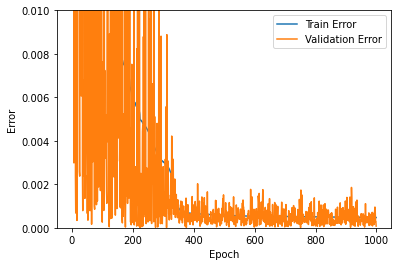

In [191]:
def plot_history(h):
    hist = pd.DataFrame(h.history)
    hist['epoch'] = h.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Validation Error')
    plt.ylim(0,0.01)
    plt.legend()
plot_history(history)    

In [192]:
print(pd.DataFrame(history.history)['mse'].min())

0.00047159125097095966
